In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics, neighbors

In [2]:
df_train = pd.read_csv("../data/embed_train.csv")
df_test = pd.read_csv("../data/embed_test.csv")
metadataDF: pd.DataFrame = pd.read_csv("../data/metaData_taxistandsID_name_GPSlocation.csv")

In [3]:
df_test.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR
0,0,14,342,1408039037,0,1,0,1,32,3,10
1,0,56,78,1408038611,0,1,0,1,32,3,10
2,0,14,239,1408038568,0,1,0,1,32,3,10
3,0,52,309,1408039090,0,1,0,1,32,3,10
4,0,17,393,1408039177,0,1,0,1,32,3,10


In [4]:
train_arr = np.loadtxt("../data/numeric_train.csv", delimiter=",", skiprows=1)
test_arr = np.loadtxt("../data/numeric_test.csv", delimiter=",", skiprows=1)

### Approximate starting coords in test set

In [5]:
KNN = dict()
for i in df_test["TAXI_ID"].unique():
    KNN[i] = neighbors.NearestNeighbors(n_neighbors=1)
    KNN[i].fit(train_arr[train_arr[:, 3] == i, 4:5])

In [6]:
# Nearest neighbors in time
coords = np.zeros((len(df_test), 2))
for i in range(len(df_test)):
    if test_arr[i, 5] == 1:
        # If call type B
        taxi_stand = test_arr[i, 1]
        coords[i] = np.array((metadataDF.iloc[int(taxi_stand)]["Longitude"], metadataDF.iloc[int(taxi_stand)]["Latitude"]))
        continue

    neighbor_idx = KNN[test_arr[i, 2]].kneighbors(test_arr[i, 3:4].reshape(1, -1), n_neighbors=1)[1][0][0]
    neighbor = df_train[df_train["TAXI_ID"] == test_arr[i, 2]].iloc[neighbor_idx]

    if neighbor["TIMESTAMP"] < test_arr[i, 3]:
        coords[i] = [neighbor["END_LONG"], neighbor["END_LAT"]]
    else:
        coords[i] = [neighbor["START_LONG"], neighbor["START_LAT"]]


In [7]:
df_test[["START_LONG", "START_LAT"]] = coords

In [8]:
df_test.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR,START_LONG,START_LAT
0,0,14,342,1408039037,0,1,0,1,32,3,10,-8.585877,41.148628
1,0,56,78,1408038611,0,1,0,1,32,3,10,-8.610707,41.145719
2,0,14,239,1408038568,0,1,0,1,32,3,10,-8.585877,41.148628
3,0,52,309,1408039090,0,1,0,1,32,3,10,-8.614012,41.141208
4,0,17,393,1408039177,0,1,0,1,32,3,10,-8.619603,41.148321


In [9]:
df_train.drop(labels="TIMESTAMP", axis=1, inplace=True)
df_test.drop(labels="TIMESTAMP", axis=1, inplace=True)

### Calculate distances from city center

In [10]:
import math
# Haversine distance assumes first coord lat second coord long
central_long = df_train[df_train["A"] == 1]["START_LONG"].median()
central_lat = df_train[df_train["A"] == 1]["START_LAT"].median()
center = np.array([central_lat, central_long], dtype=np.float64)
center = np.radians(center)

coords_train = df_train[["START_LAT", "START_LONG"]].to_numpy()
coords_train = np.radians(coords_train)
dists_train = metrics.pairwise.haversine_distances(coords_train, center.reshape(1, -1))
dists_train *= 6371000/1000
coords_test = df_test[["START_LAT", "START_LONG"]].to_numpy()
coords_test = np.radians(coords_test)
dists_test = metrics.pairwise.haversine_distances(coords_test, center.reshape(1, -1))
dists_test *= 6371000/1000

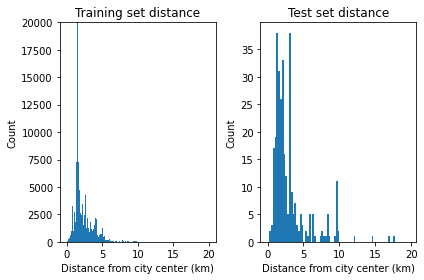

In [13]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.title("Training set distance")
plt.hist(dists_train, bins=np.arange(0, 20, 0.01))
plt.xlabel("Distance from city center (km)")
plt.ylabel("Count")
plt.ylim(0, 20000)
plt.subplot(1, 2, 2)
plt.title("Test set distance")
plt.hist(dists_test, bins=np.arange(0, 20, 0.25))
plt.xlabel("Distance from city center (km)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [30]:
df_train["DIST"] = dists_train
df_test["DIST"] = dists_test

In [31]:
df_train.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LONG,START_LAT,END_LONG,END_LAT,A,B,C,YEAR,WK_OF_YR,WK_DAY,HR,TARGET,DIST
0,0,63,367,-8.618643,41.141412,-8.630838,41.154489,0,0,1,0,25,6,17,345,2.008737
1,0,6,371,-8.639847,41.159826,-8.665740,41.170671,0,1,0,0,25,6,17,285,1.661882
2,0,63,204,-8.612964,41.140359,-8.615970,41.140530,0,0,1,0,25,6,17,975,2.202881
3,0,63,330,-8.574678,41.151951,-8.607996,41.142915,0,0,1,0,25,6,17,645,3.885076
4,0,63,217,-8.645994,41.180490,-8.687268,41.178087,0,0,1,0,25,6,17,435,3.194961


In [32]:
# Reorder columns
df_train.drop(columns=["END_LONG", "END_LAT"], inplace=True)
df_train.head()
cols = ["ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "START_LONG", "START_LAT", "A", "B", "C", "YEAR", "WK_OF_YR", "WK_DAY", "HR", "DIST", "TARGET"]
df_train = df_train[cols]
df_test = df_test[cols[:-1]]

### Remove outliers

In [33]:
# df_train.drop(df_train[df_train["DIST"] > 40].index, inplace=True)
# df_train.drop(df_train[df_train["TARGET"] < 50].index, inplace=True)
# df_train.drop(df_train[df_train["TARGET"] > 15000].index, inplace=True)

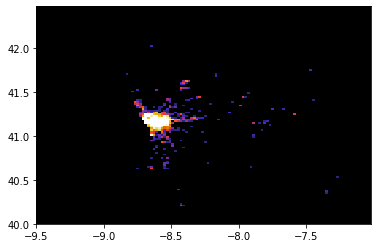

In [34]:
bucket_interval = 0.02
from matplotlib.colors import LogNorm
plt.hist2d(df_train["START_LONG"], df_train["START_LAT"], bins=[np.arange(-9.5, -7, bucket_interval),np.arange(40, 42.5, bucket_interval)], norm=LogNorm(vmax=200, clip=True), cmap="CMRmap")
plt.show()

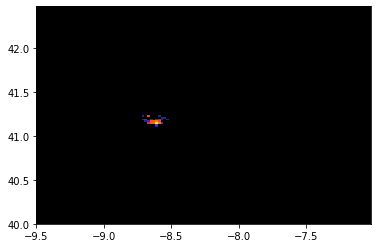

In [35]:
bucket_interval = 0.02
from matplotlib.colors import LogNorm
plt.hist2d(df_test["START_LONG"], df_test["START_LAT"], bins=[np.arange(-9.5, -7, bucket_interval),np.arange(40, 42.5, bucket_interval)], norm=LogNorm(vmax=200, clip=True), cmap="CMRmap")
plt.show()

### Split to train and validation sets

In [36]:
# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_valid = df_train[int(0.9 * len(df_train)):]
# df_train = df_train[:int(0.9 * len(df_train))]
df_train.to_csv("../data/numeric_trainvf.csv", index=True)
# df_valid.to_csv("data/embed_validvf.csv", index=False)
df_test.to_csv("../data/numeric_testvf.csv", index=False)
